In [1]:
import numpy,copy
import modules,utils

Fully-connected neural network:
    two hidden layers of size 300 and 100 and ReLU activation on both hidden layers
    100 epochs
    1.05% test error on the MNIST test set

The network has been stripped from its trailing softmax layer. 
The output of the network corresponds to unnormalized class log-probabilities which is used to explain the input pixels.

In [47]:
nn = modules.Network([
    modules.Linear('mlp/l1'),modules.ReLU(),
    modules.Linear('mlp/l2'),modules.ReLU(),
    modules.Linear('mlp/l3'),
])

# Implementing the propagation procedure

We first implement the global propagation procedure from the top to the bottom of the network. The class Network defined below extends the original neural network class and adds a method "relprop" that performs such propagation.

The method iteratively visits layers of the network in reverse order, call the propagation function on each individual layers, and feed the output to the function of the previous layer.

In [48]:
class Network(modules.Network):
    def relprop(self,R):
        for l in self.layers[::-1]: R = l.relprop(R)
        return R

LRP considers as a layer the pairing of a linear and ReLU layer, as one option would be to change the neural network implementation by merging these two layers into one. Alternatively, we can simply propagate the signal through the ReLU layer without transformation and implement the full propagation rule in the linear layer just below.

In [49]:
class ReLU(modules.ReLU):
    def relprop(self,R): return R

The choice of propagation rule for a linear-detection layer depends on its input domain. The z+-rule applies to layers with positive input domain (e.g. hidden layers receiving as input the ReLU features of a previous layer). 

The zB-rule, applies to box-constrained domains (e.g. input layer receiving as input pixel values).

We call this class NextLinear to emphasize that the associated propagation method does not apply to the first layer but to the layers following it.

In [50]:
class NextLinear(modules.Linear):
    def relprop(self,R):
        V = numpy.maximum(0,self.W)
        Z = numpy.dot(self.X,V)+1e-9; S = R/Z
        C = numpy.dot(S,V.T);         R = self.X*C
        return R

We create a class extension of modules.Linear and call the specialized class FirstLinear to emphasize that it applies only to the first layer of the network.

In [51]:
class FirstLinear(modules.Linear):
    def relprop(self,R):
        W,V,U = self.W,numpy.maximum(0,self.W),numpy.minimum(0,self.W)
        X,L,H = self.X,self.X*0+utils.lowest,self.X*0+utils.highest

        Z = numpy.dot(X,W)-numpy.dot(L,V)-numpy.dot(H,U)+1e-9; S = R/Z
        R = X*numpy.dot(S,W.T)-L*numpy.dot(S,V.T)-H*numpy.dot(S,U.T)
        return R

# Application to MNIST data

The following code randomly samples 12 MNIST handwritten digits and displays them.

In [52]:
X,T = utils.getMNISTsample(N=12,path='mnist',seed=1234)
utils.visualize(X,utils.graymap,'data.png')

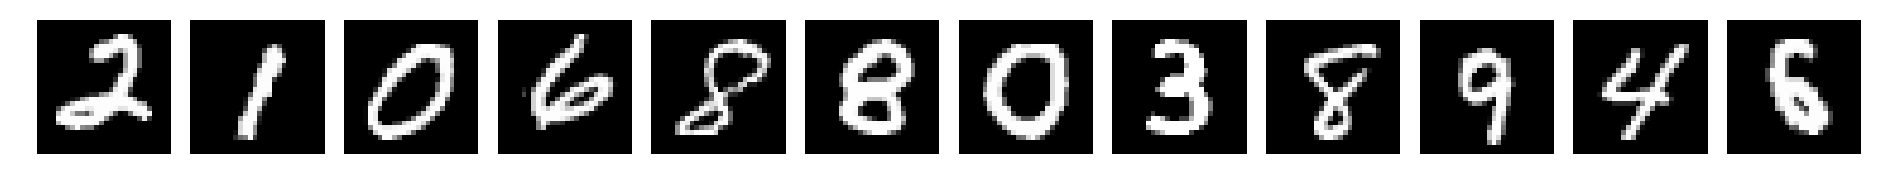

In [53]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

def display_image_in_actual_size(im_path):

    dpi = 60
    im_data = plt.imread(im_path)
    height, width, depth = im_data.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width*2 / float(dpi), height*2 / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

display_image_in_actual_size("data.png")

In [54]:
Y = nn.forward(X)
S = nn.gradprop(T)**2
utils.visualize(S,utils.heatmap,'mlp-sensitivity.png')

We first perform a sensitivity analysis of the neural network. The sensitivity scores do not really explain why an image has been predicted in a certain way, 
but rather to which direction in the pixel space the output is most sensitive to.

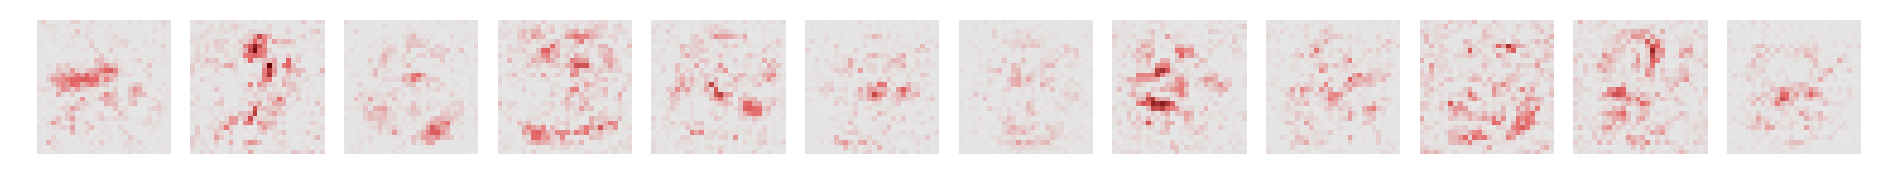

In [55]:
display_image_in_actual_size("mlp-sensitivity.png")

To perform relevance propagation, we first need to reinstantiate the neural network using the specialized classes that we have implemented:

In [56]:
nn = Network([
    FirstLinear('mlp/l1'),ReLU(),
    NextLinear('mlp/l2'),ReLU(),
    NextLinear('mlp/l3'),ReLU(),
])

Note that we have added a trailing ReLU layer, which was not there in the original network. It serves to complete the final linear/detection layer. From this modification, it should be clear that one can only explain positive-valued predictions. The global relevance propagation procedure consists of following three steps:

1- Run a feed-forward pass on the network to collect neuron activations at each layer.

2- Keep only the part of the neural network output that corresponds to the correct class.

3- Call the relprop method to backpropagate the neural network output.

The following code applies this sequence of operations and visualizes the resulting heatmaps.

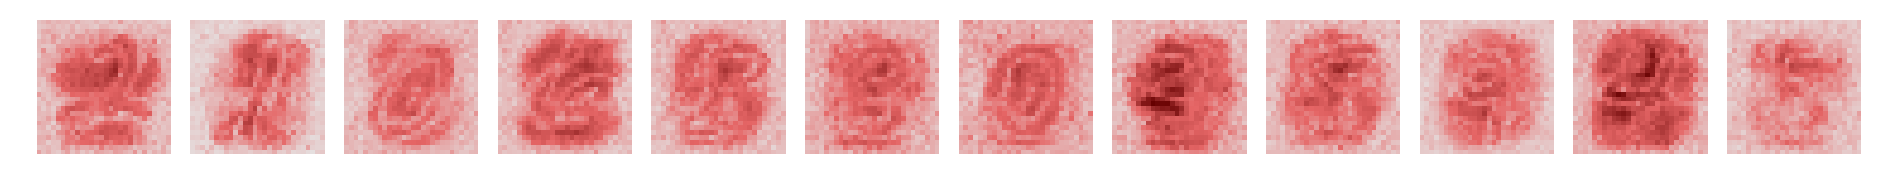

In [57]:
Y = nn.forward(X)
D = nn.relprop(Y*T)
utils.visualize(D,utils.heatmap,'mlp-deeptaylor.png')
display_image_in_actual_size("mlp-deeptaylor.png")

The heatmaps produced by relevance propagation are fuller than those obtained by sensitivity analysis. In particular, heat is spread more exhaustively on the contour of the digit. Nevertheless, the quality of the explanation is still limited by modeling artefacts of the neural network. In the next section, we implement relevance propagation for a convolutional neural network where modeling artefacts are less pronounced, and where better explanations of class membership can be obtained.

# Relevance Propagation for Convolutional Neural Networks

We consider a Lenet-5 type network, where sigmoid nonlinearities are replaced by ReLU units, with a few more feature maps in early layers, and where we add one top-level pooling layer to further increase global translation invariance. The convolutional neural network is depicted below.

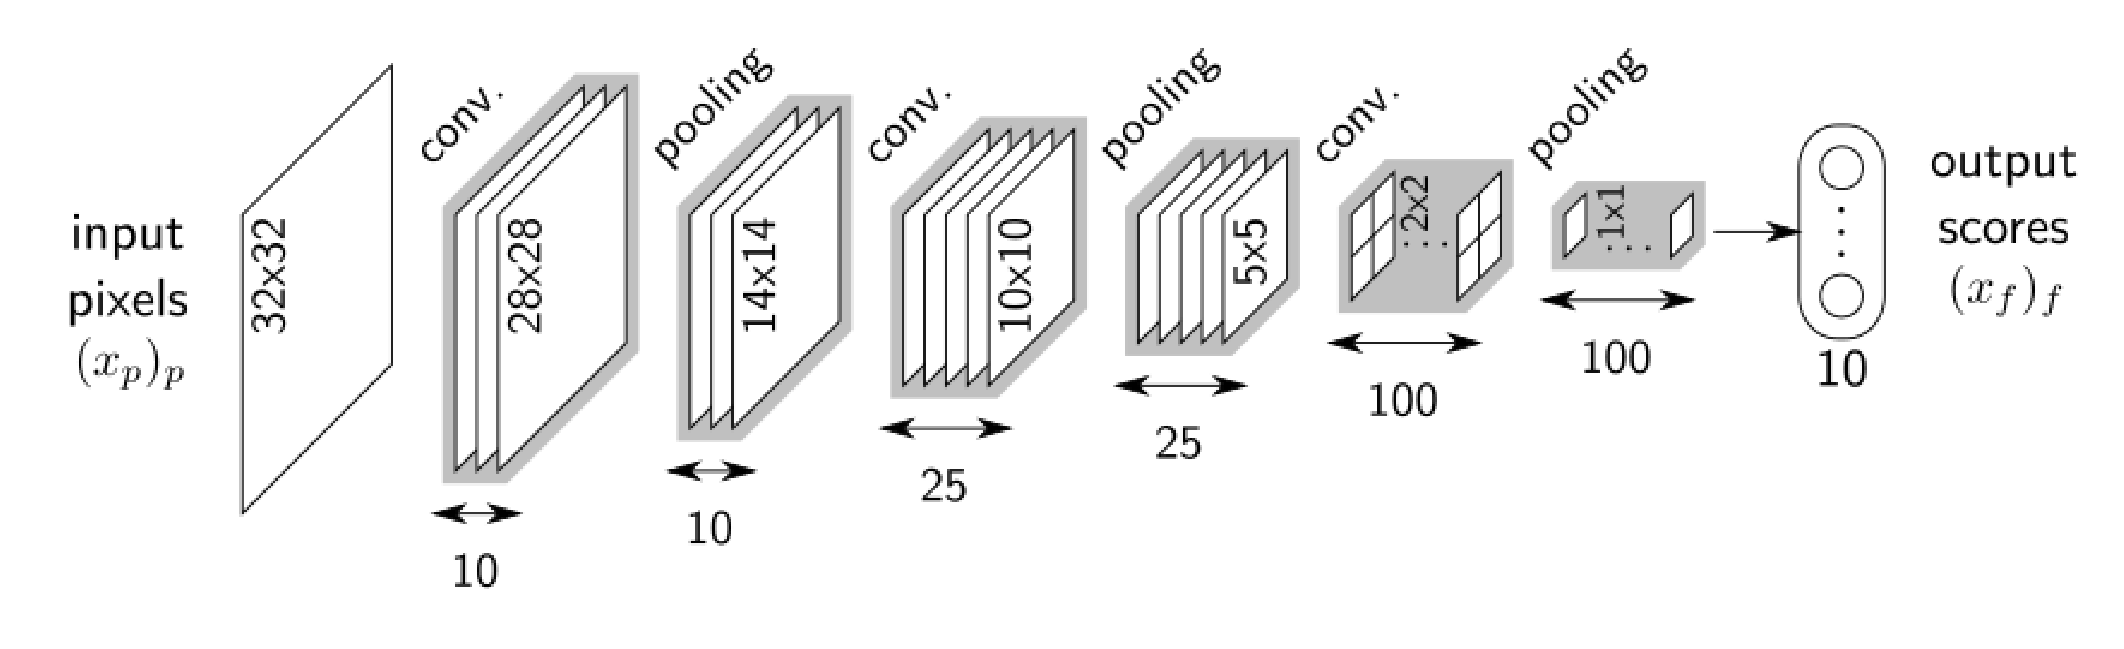

In [58]:
display_image_in_actual_size("cnn.png")

The neural network was trained for 10 epochs without data augmentation and reaches 0.76% test error on MNIST. 

We have removed the trailing softmax layer, and therefore, the quantities that will be explained are the unnormalized class log-probabilities.

In [67]:
import tarfile
tar = tarfile.open("cnn.tar.gz", "r:gz")
tar.extractall()
tar.close()

In [8]:
cnn = modules.Network([
    modules.Convolution('cnn/c1-5x5x1x10'),modules.ReLU(),modules.Pooling(),
    modules.Convolution('cnn/c2-5x5x10x25'),modules.ReLU(),modules.Pooling(),
    modules.Convolution('cnn/c3-4x4x25x100'),modules.ReLU(),modules.Pooling(),
    modules.Convolution('cnn/c4-1x1x100x10'),
])

In [9]:
class NextConvolution(modules.Convolution):
    def relprop(self,R):
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum(0,pself.W)

        Z = pself.forward(self.X)+1e-9; S = R/Z
        C = pself.gradprop(S);          R = self.X*C
        return R

In [10]:
class FirstConvolution(modules.Convolution):
    def relprop(self,R):
        iself = copy.deepcopy(self); iself.B *= 0
        nself = copy.deepcopy(self); nself.B *= 0; nself.W = numpy.minimum(0,nself.W)
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum(0,pself.W)
        X,L,H = self.X,self.X*0+utils.lowest,self.X*0+utils.highest

        Z = iself.forward(X)-pself.forward(L)-nself.forward(H)+1e-9; S = R/Z
        R = X*iself.gradprop(S)-L*pself.gradprop(S)-H*nself.gradprop(S)
        return R

In [11]:
class Pooling(modules.Pooling):
    def relprop(self,R):
        Z = (self.forward(self.X)+1e-9); S = R / Z
        C = self.gradprop(S);            R = self.X*C
        return R

# Application to MNIST data

To serve as input to the convolutional neural network, the MNIST images need to be reshaped and padded to shape 32x32x1. A similar reshaping operation is also applied to the labels.

In [12]:
X,T = utils.getMNISTsample(N=12,path='mnist/',seed=1234)

padding = ((0,0),(2,2),(2,2),(0,0))
X = numpy.pad(X.reshape([12,28,28,1]),padding,'constant',constant_values=(utils.lowest,))
T = T.reshape([12,1,1,10])

In [14]:
X.shape

(12, 32, 32, 1)

As a basis for comparison, we perform sensitivity analysis, as we did for the fully-connected case.

In [13]:
Y = cnn.forward(X)
S = cnn.gradprop(T)**2
utils.visualize(S[:,2:-2,2:-2],utils.heatmap,'cnn-sensitivity_new.png')

ValueError: not enough values to unpack (expected 4, got 1)

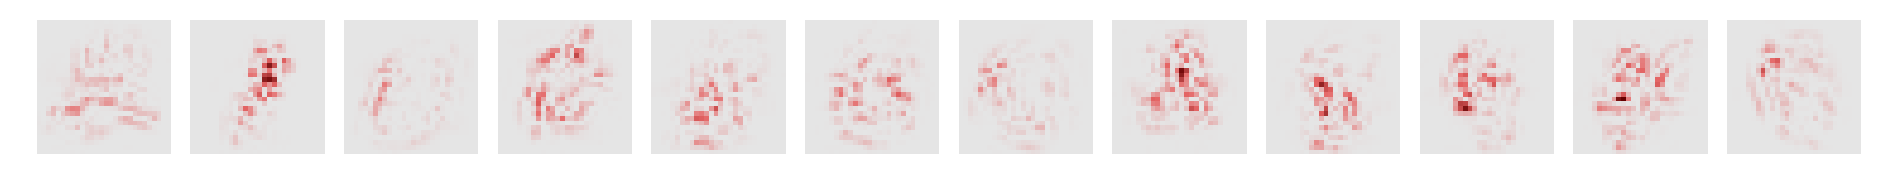

In [27]:
display_image_in_actual_size("cnn-sensitivity.png")

The result is similar to the sensitivity analysis of the previous network, in particular, heatmaps are sparse and reflect local variations of the neural network function rather than producing a global explanation.

To apply relevance propagation, we need to reinstantiate the neural network with the newly defined specialized classes. We also add a top-level ReLU layer in order to complete the last linear-detection layer.

In [75]:
cnn = Network([
    FirstConvolution('cnn/c1-5x5x1x10'),ReLU(),Pooling(),
    NextConvolution('cnn/c2-5x5x10x25'),ReLU(),Pooling(),
    NextConvolution('cnn/c3-4x4x25x100'),ReLU(),Pooling(),
    NextConvolution('cnn/c4-1x1x100x10'),ReLU(),
])

In [76]:
Y = cnn.forward(X)
D = cnn.relprop(Y*T)
utils.visualize(D[:,2:-2,2:-2],utils.heatmap,'cnn-deeptaylor_new.png')

ValueError: not enough values to unpack (expected 4, got 1)

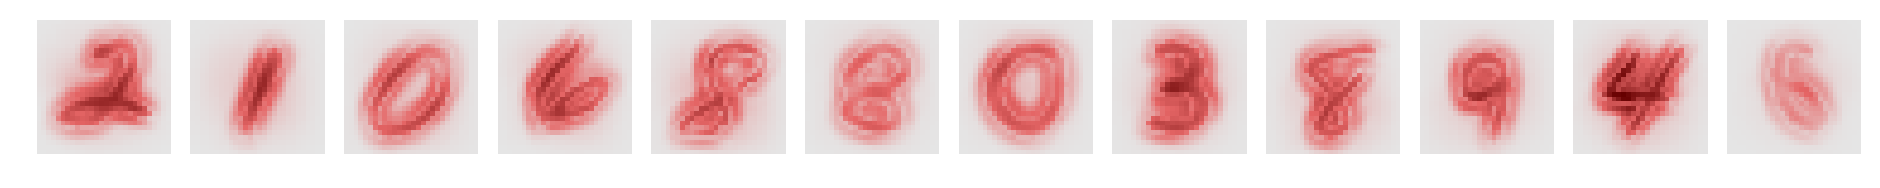

In [28]:
display_image_in_actual_size("cnn-deeptaylor.png")

Heatmaps are more complete than those obtained with sensitivity analysis, and more consistently follow the contour of the digits. The heatmaps are also of better quality than those obtained by the fully-connected network, in particular, they are more focused on the contour of the digit and ignore the non-digit area of the image.

In order to produce more focused heatmaps, it was shown to be useful to inject some negative relevance into the redistribution process. A possible implementation of this rule is shown below for the convolution layer:

In [78]:
cnn = Network([
    FirstConvolution('cnn/c1-5x5x1x10'),ReLU(),Pooling(),
    NextConvolutionAlphaBeta('cnn/c2-5x5x10x25',2.0),ReLU(),Pooling(),
    NextConvolutionAlphaBeta('cnn/c3-4x4x25x100',2.0),ReLU(),Pooling(),
    NextConvolutionAlphaBeta('cnn/c4-1x1x100x10',2.0),ReLU(),
])

In [77]:
class NextConvolutionAlphaBeta(modules.Convolution,object):

    def __init__(self,name,alpha):
        super(self.__class__, self).__init__(name)
        self.alpha = alpha
        self.beta  = alpha-1
        
    def relprop(self,R):
        pself = copy.deepcopy(self); pself.B *= 0; pself.W = numpy.maximum( 1e-9,pself.W)
        nself = copy.deepcopy(self); nself.B *= 0; nself.W = numpy.minimum(-1e-9,nself.W)

        X = self.X+1e-9
        ZA = pself.forward(X); SA =  self.alpha*R/ZA
        ZB = nself.forward(X); SB = -self.beta *R/ZB
        R = X*(pself.gradprop(SA)+nself.gradprop(SB))
        return R

Finally, the predictions and explanations are computed by running a forward and backward pass in this network.

In [79]:
Y = cnn.forward(X)
D = cnn.relprop(Y*T)
utils.visualize(D[:,2:-2,2:-2],utils.heatmap,'cnn-alphabeta_new.png')

ValueError: not enough values to unpack (expected 4, got 1)

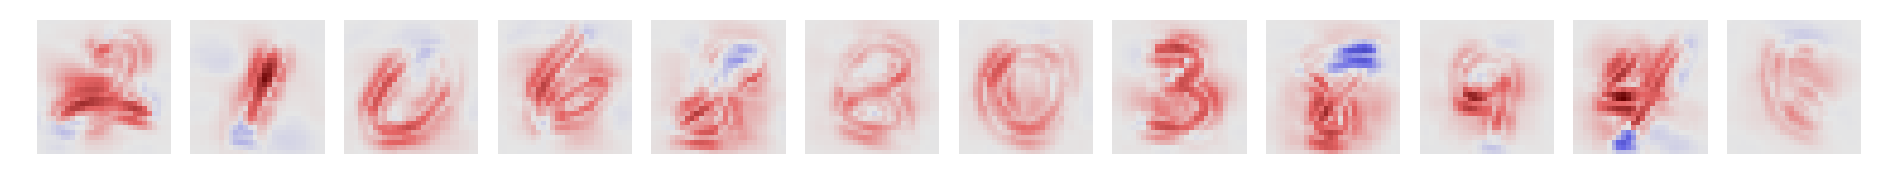

In [29]:
display_image_in_actual_size("cnn-alphabeta.png")

Unlike the standard deep Taylor LRP heatmaps, the heatmaps obtained with LRP-
α
β
 typically contain some negative relevance (shown in blue). This negative relevance points potentially at local irregularities of the digit such as the broken loop in the last digit "8". The heatmaps also tend to be sparser.